In [1]:
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def read_imgs(dir):
    ret = []
    names = os.listdir(dir)
    for name in names:
        if not name.endswith('jpg') :
            continue
        path = os.path.join(dir,name)
        img = cv2.cv2.imread(path)
        img = cv2.cv2.cvtColor(img,cv2.cv2.COLOR_BGR2RGB)
        ret.append(img)
    return ret
        

In [3]:
import numpy as np
# all_imgs = read_imgs('./faces/')
# np.save('./all_imgs.npy',imgs)
all_imgs = np.load('./all_imgs.npy')

In [4]:
import torch
from torch.utils.data import DataLoader,Dataset
from torch import nn
import torchvision
import numpy as np
from torchvision import transforms

In [5]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((64,64)),
                               transforms.ToTensor()])
class ImgDataSet(Dataset):
    def __init__(self,x,transform = transform):
        self.x = x
        self.transform = transform
        self.len = len(x)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,index):
        return transform(self.x[index])

In [6]:
class Generate(nn.Module):
    def make_layer(self,in_dim,out_dim):
        layer = nn.Sequential(
            nn.ConvTranspose2d(in_dim,out_dim,3,2,1,1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU()
            )
        return layer
    def __init__(self,z_dim):
        super(Generate,self).__init__()
        self.z_dim = z_dim
        self.dim = 64
        self.fc = nn.Linear(self.z_dim,self.dim*8*4*4)
        self.convTrans = nn.Sequential(
                self.make_layer(self.dim*8,self.dim*4),   
                self.make_layer(self.dim*4,self.dim*2),
                self.make_layer(self.dim*2,self.dim),
                nn.ConvTranspose2d(self.dim,3,3,2,1,1),
                nn.Sigmoid()
            )
    def forward(self,x):
        x = self.fc(x)
        x = x.view(x.size(0),-1,4,4)
        x = self.convTrans(x)
        return x
        

In [7]:
class Discriminate(nn.Module):
    def make_layer(self,in_dim,out_dim):
        layer = nn.Sequential(
            nn.Conv2d(in_dim,out_dim,3,1,1),
#             nn.BatchNorm2d(out_dim),
            nn.InstanceNorm2d(out_dim),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
            )
        return layer
    def __init__(self):
        super(Discriminate,self).__init__()
        dim = 64
        self.conv = nn.Sequential(
                self.make_layer(3,dim),
                self.make_layer(dim,dim*2),
                self.make_layer(dim*2,dim*4),
                self.make_layer(dim*4,dim*8),
                nn.Conv2d(dim * 8, 1, 4),
                nn.Sigmoid()
            )
    def forward(self,x):
        x = self.conv(x)
        x = x.view(-1)
        return x

In [8]:
batch_size = 128
dataset = ImgDataSet(all_imgs)
loader = DataLoader(dataset,batch_size,shuffle=True)

In [9]:
G = Generate(100).cuda()
D = Discriminate().cuda()

In [10]:
n_epoch = 10
loss = nn.BCELoss()
lr = 1e-4
optimG = torch.optim.Adam(G.parameters(),lr,betas=(0.5,0.99))
optimD = torch.optim.Adam(D.parameters(),lr,betas=(0.5,0.99))

epoch[0/10 557/557 loss_d=0.065 loss_g=4.804]

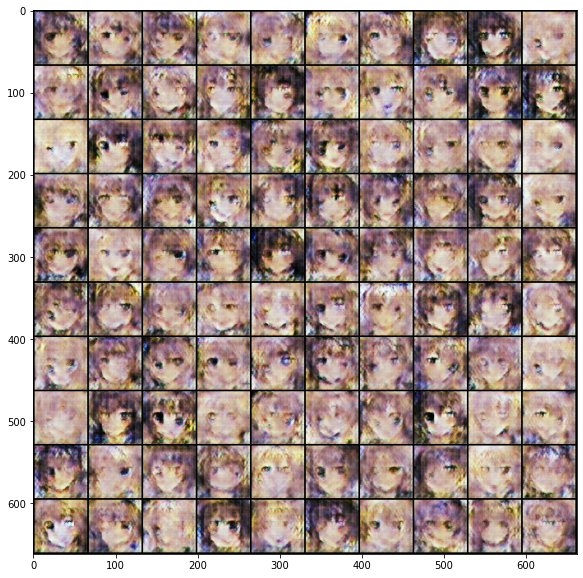

epoch[1/10 557/557 loss_d=0.093 loss_g=3.899]

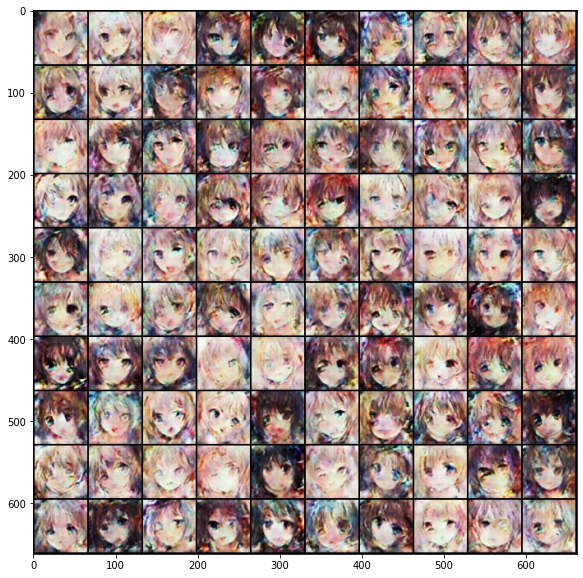

epoch[2/10 557/557 loss_d=0.103 loss_g=3.923]

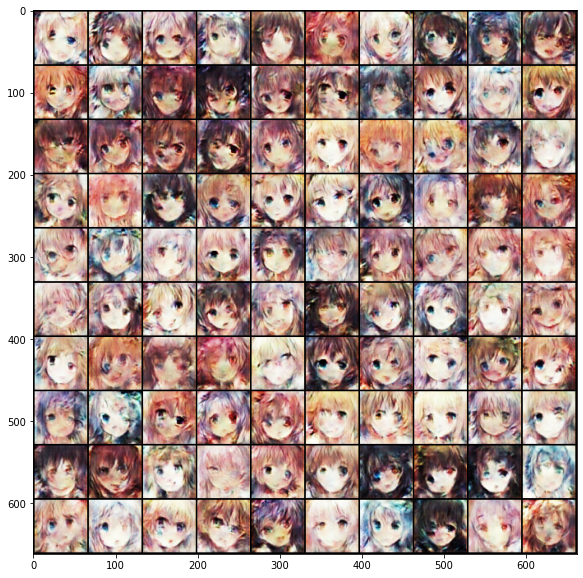

epoch[3/10 557/557 loss_d=0.115 loss_g=3.839]

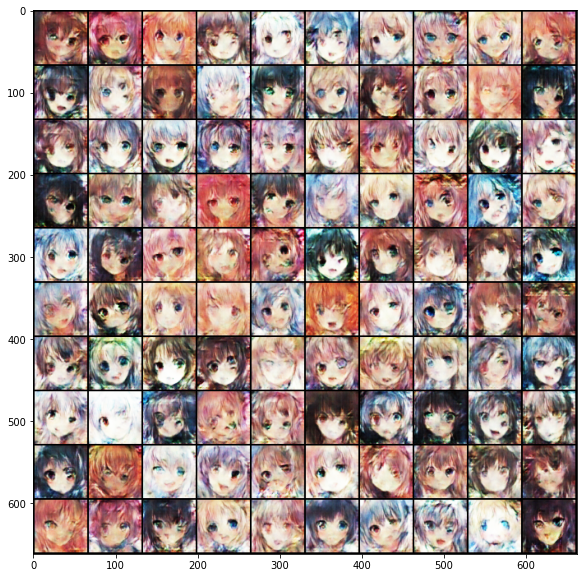

epoch[4/10 557/557 loss_d=0.098 loss_g=3.795]

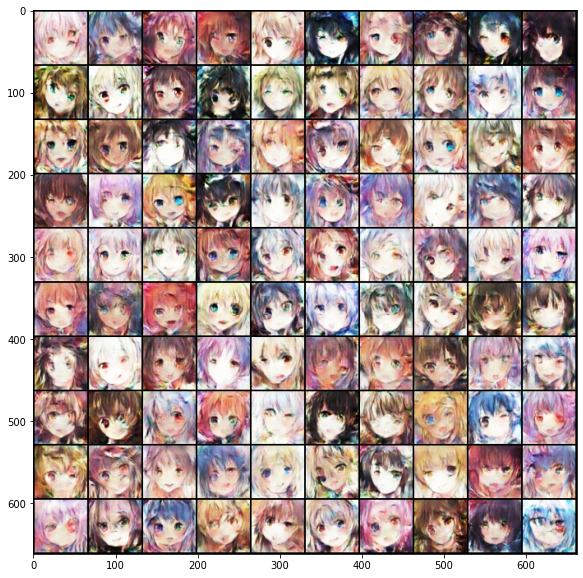

epoch[5/10 557/557 loss_d=0.104 loss_g=3.803]

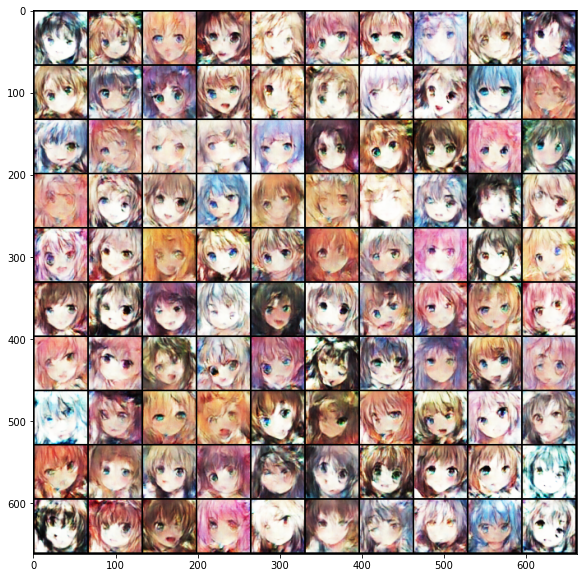

epoch[6/10 557/557 loss_d=0.104 loss_g=3.921]

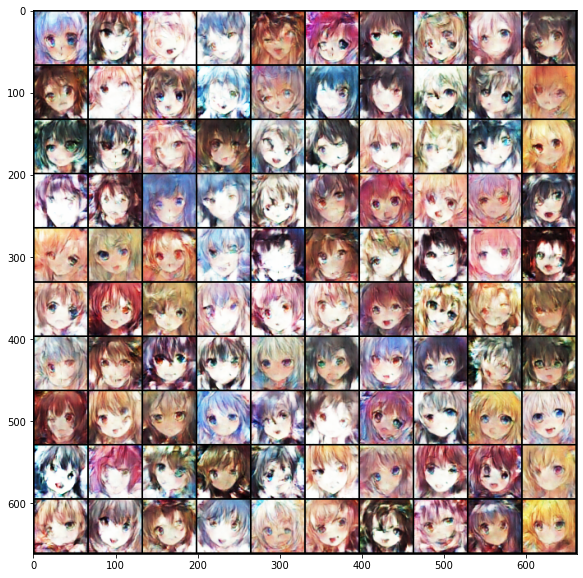

epoch[7/10 557/557 loss_d=0.099 loss_g=3.966]

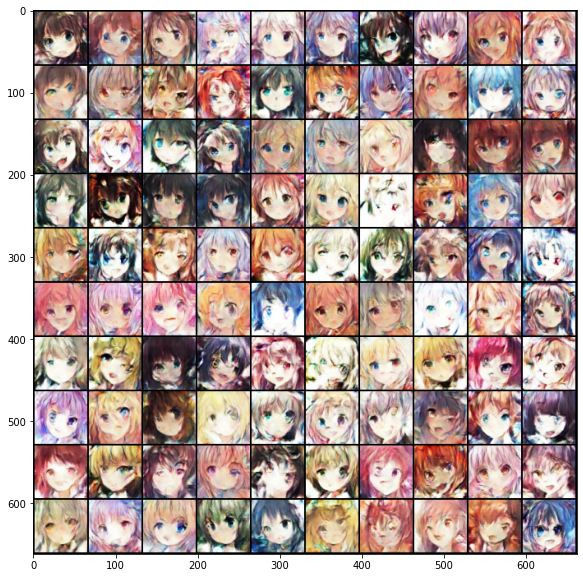

epoch[8/10 557/557 loss_d=0.090 loss_g=4.025]

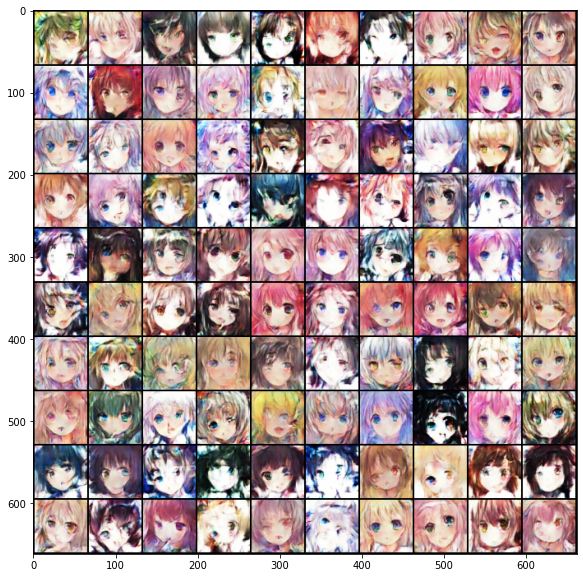

epoch[9/10 557/557 loss_d=0.092 loss_g=4.119]

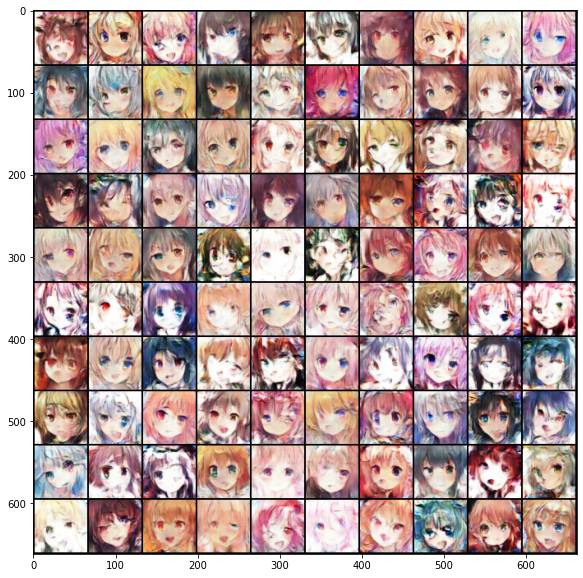

In [11]:

for epoch in range(n_epoch):
    batch_len = int(len(dataset)//batch_size)
    D_loss =[]
    G_loss =[]
    G.train()
    D.train()
    for i,data in enumerate(loader):
        r_img = data.cuda()
        z = torch.randn((r_img.size(0),100)).cuda()
        f_img = G(z)
        r_label = torch.ones((r_img.size(0)))
        f_label = r_label*0
        
        r_output = D(r_img)
        f_output = D(f_img)
        
        r_loss = loss(r_output.cpu(),r_label)
        f_loss = loss(f_output.cpu(),f_label)
        
        l_d = (r_loss+f_loss)/2
        D_loss.append(l_d.item())
        D.zero_grad()
        l_d.backward()
        optimD.step()
        
        z = torch.randn((r_img.size(0),100)).cuda()
        f_img = G(z)
        f_output = D(f_img)
        l_g = loss(f_output.cpu(),r_label)
        G_loss.append(l_g.item())
        G.zero_grad()
        l_g.backward()
        optimG.step()
        
        print(f"\repoch[%d/%d %d/%d loss_d=%0.3f loss_g=%0.3f]"%(epoch,n_epoch,i,batch_len,np.mean(D_loss),np.mean(G_loss)), end='')
    G.eval()
    with torch.no_grad():
        z = torch.randn((100,100)).cuda()
        g_img = G(z)
        grid_img = torchvision.utils.make_grid(g_img.cpu(), nrow=10)
        plt.figure(figsize=(10,10))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.show()
    
    
        